# MNIST Digit Classification

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import os.path as P
import typing as T

In [2]:
torch.manual_seed(42)

## Download the Dataset and Creating the Data Loaders

Let's first begin by downloading the dataset. Given it's popularity, many deep learning frameworks already ship with tools to download it, and Pytorch is no exception.

In [3]:
dataset_root = "data"

In [4]:
checkpoints_root = "checkpoints"

In [5]:
batch_size = 64

In [6]:
train_set = datasets.MNIST(
    root=dataset_root,
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_set = datasets.MNIST(
    root=dataset_root,
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Let's check one of the batches.

Each image has 28x28 pixels and is is assigned to a interger number. Let's plot some of those images and their labels.

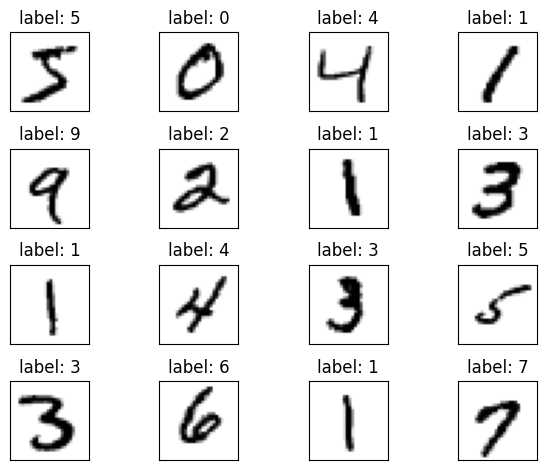

In [7]:
fig = plt.figure()
for i in range(16):
    img, lbl = train_set[i]
    img = img.numpy().squeeze()
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap="gray_r")
    plt.title(f"label: {lbl}")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

We can see that some of the digits more recongnizable than others.

## Create the Convolutional Neural Network

Let's build Yann LeCun's LeNet, the famous Convolutional Neural Network.

In [8]:
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = F.relu(F.max_pool2d(self.conv1(X), 2))
        X = F.relu(F.max_pool2d(self.conv2(X), 2))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

We'll also initialize the network's weights using Xavier initialization.

In [9]:
def init_weights(m: nn.Module) -> None:
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

net = Network()
net.apply(init_weights)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next we'll detect if we can use CUDA to speed up training.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
net.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Last, we define the optimizer.

In [12]:
learning_rate = 0.01
momentum = 0.5

In [13]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## Predictor Class

The original model class outputs raw logits for each class. Now we want real probabilities for each class.

In [14]:
class MNISTPredictor(nn.Module):
    def __init__(self, model: nn.Module, device: str) -> None:
        super().__init__()
        self.model = model
        self.device = device
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            X = F.softmax(self.model(X), dim=1).detach()
        return X

## Train the model

We'll define two functions: one for the train step e one for the validation step.

In [15]:
def train_step(
    loader: DataLoader, net: nn.Module, optimizer: optim.Optimizer, device: str
) -> (int, int):
    net.train()
    
    train_loss = 0
    train_corrects = 0
    
    for data, target in iter(loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_predictions = output.data.max(1, keepdim=True)[1]
            train_corrects += train_predictions.eq(target.data.view_as(train_predictions)).sum().item()
        
    return train_loss, train_corrects

In [16]:
def test_step(
    loader: DataLoader, net: nn.Module, device: str
) -> (int, int):
    net.eval()
    
    test_loss = 0
    test_corrects = 0
    
    with torch.no_grad():
        for data, target in iter(loader):
            data, target = data.to(device), target.to(device)
            
            output = net(data)
            
            loss = F.cross_entropy(output, target)
            
            test_loss += loss.item()
            test_predictions = output.data.max(1, keepdim=True)[1]
            test_corrects += test_predictions.eq(target.data.view_as(test_predictions)).sum().item()
    
    return test_loss, test_corrects

In [17]:
def save_checkpoint(
    net: nn.Module,
    optimizer: optim.Optimizer,
    test_loss: float,
    test_acc: float,
    epoch: int,
    model_filename: str
) -> None:
    state_dict = {
        "model": net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "test_loss": test_loss,
        "test_acc": test_acc,
        "epoch": epoch
    }
    
    if not P.isdir(checkpoints_root):
        os.makedirs(checkpoints_root)
    
    ckpt_filepath = P.join(checkpoints_root, f"{model_filename}.pth")
    torch.save(state_dict, ckpt_filepath)

In [18]:
def load_checkpoint(model_filename: str) -> dict:
    ckpt_filepath = P.join(checkpoints_root, f"{model_filename}.pth")
    if not P.isfile(ckpt_filepath):
        raise RuntimeError(f"{ckpt_filepath} doesn't exists!")
    state_dict = torch.load(ckpt_filepath)
    return state_dict

In [19]:
def run_training(
    net: nn.Module,
    optimizer: optim.Optimizer,
    train_set: datasets.VisionDataset,
    test_set: datasets.VisionDataset,
    device: str,
    n_epochs: int,
    model_filename: T.Optional[str] = None
) -> None:
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    if model_filename:
        state_dict = load_checkpoint(model_filename)
        net.load_state_dict(state_dict["model"])
        optimizer.load_state_dict(state_dict["optimizer"])
        test_loss = state_dict["test_loss"]
        test_acc = state_dict["test_acc"]
        last_epoch = state_dict["epoch"]
    else:
        last_epoch = 0
    
    for epoch in range(last_epoch, n_epochs):
        train_loss, train_corrects = train_step(
            train_loader, net, optimizer, device
        )
        train_loss /= len(train_loader)
        train_acc = train_corrects / len(train_set)
        print(f"Train epoch {epoch} -- Loss: {train_loss:.4f} -- Acc: {train_acc:.4f} [{train_corrects}/{len(train_set)}]")
        
    test_loss, test_corrects = test_step(
        test_loader, net, device
    )
    test_loss /= len(test_loader)
    test_acc = test_corrects / len(test_set)
    print(f"Test -- Loss: {test_loss:.4f} -- Acc: {test_acc:.4f} [{test_corrects}/{len(test_set)}]")
    
    save_checkpoint(net, optimizer, test_loss, test_acc, epoch, "latest")

In [20]:
run_training(net, optimizer, train_set, test_set, device, 5)

Train epoch 0 -- Loss: 0.5017 -- Acc: 0.8424 [50542/60000]
Train epoch 1 -- Loss: 0.1221 -- Acc: 0.9622 [57731/60000]
Train epoch 2 -- Loss: 0.0883 -- Acc: 0.9727 [58363/60000]
Train epoch 3 -- Loss: 0.0720 -- Acc: 0.9773 [58636/60000]
Train epoch 4 -- Loss: 0.0615 -- Acc: 0.9808 [58848/60000]
Test -- Loss: 0.0592 -- Acc: 0.9803 [9803/10000]


## Model Evaluation

Now we'll plot some predictions.

In [21]:
def plot_pred(
    probabilities: np.ndarray,
    labels: np.ndarray,
    images: np.ndarray,
    sample_idx: int = 0,
    starting_idx: int = 0
):
    probs, lbl, img = probabilities[sample_idx], labels[sample_idx], images[sample_idx]
    prediction = np.argmax(probs)
    prediction_prob = np.max(probs)
    
    plt.imshow(img, cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    
    color = "green" if prediction == lbl else "red"
    
    plt.title(
        f"id: {starting_idx + sample_idx}\nprediction: {prediction} ({prediction_prob*100:2.0f}%) label: {lbl}",
        color=color
    )

In [22]:

def plot_pred_conf(
    probabilities: np.ndarray,
    labels: np.ndarray,
    sample_idx: int = 0
) -> None:
    probs, lbl = probabilities[sample_idx], labels[sample_idx]
    
    prediction = np.argmax(probs)
    
    plot = plt.bar([str(i) for i in range(10)], probs, color="gray")
    
    if prediction == lbl:
        plot[prediction].set_color("green")
    else:
        plot[prediction].set_color("red")
        plot[lbl].set_color("blue")

In [23]:
def display_samples(
    predictor: nn.Module,
    data_set: datasets.VisionDataset,
    samples_start_idx: int
) -> None:
    images, sample_labels = [], []
    for i in range(samples_start_idx, samples_start_idx + 12):
        img, lbl = data_set[i]
        images.append(img[None, :])
        sample_labels.append(lbl)
    
    images = torch.concat(images).to(device)

    sample_predictions = predictor(images).to("cpu").numpy()
    sample_images = images.permute(0, 2, 3, 1).to("cpu").numpy()
    
    n_rows = 4
    n_cols = 3
    n_images = n_cols * n_rows

    plt.figure(figsize=(7 * n_cols, 3 * n_rows))
    for i in range(n_images):
        plt.subplot(n_rows, 2 * n_cols, 2 * i + 1)
        plot_pred(sample_predictions, sample_labels, sample_images, i, samples_start_idx)
        plt.subplot(n_rows, 2 * n_cols, 2 * i + 2)
        plot_pred_conf(sample_predictions, sample_labels, i)

    plt.tight_layout()
    plt.show()

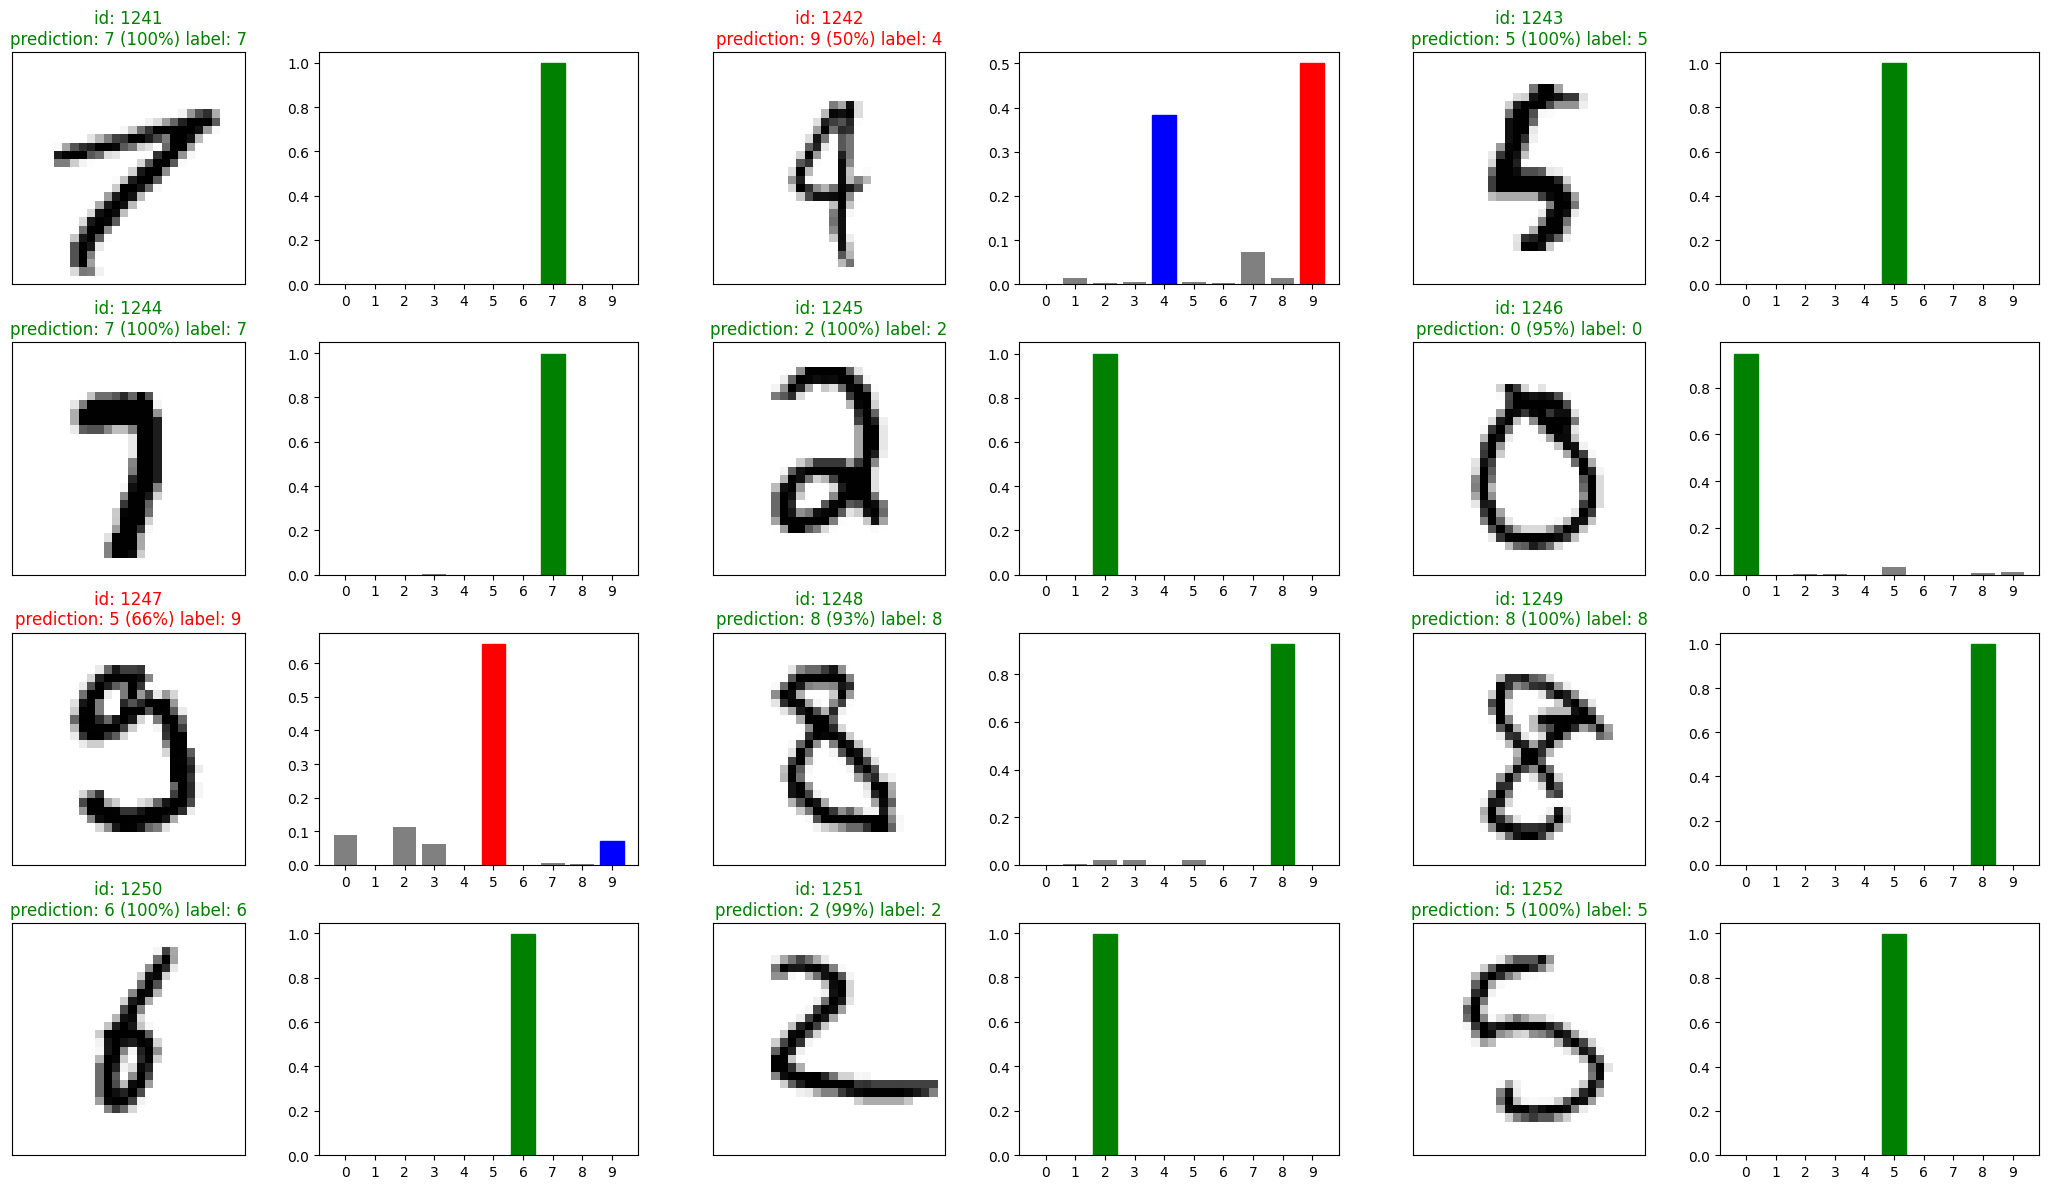

In [24]:
display_samples(MNISTPredictor(net, device), test_set, 1241)

## Resume training

In [25]:
resumed_model = Network().to(device)

learning_rate = 0.01
momentum = 0.5
resumed_optimizer = optim.SGD(resumed_model.parameters(), lr=learning_rate, momentum=momentum)

In [26]:
run_training(resumed_model, resumed_optimizer, train_set, test_set, device, 10, "latest")

Train epoch 4 -- Loss: 0.0540 -- Acc: 0.9826 [58954/60000]
Train epoch 5 -- Loss: 0.0483 -- Acc: 0.9849 [59094/60000]
Train epoch 6 -- Loss: 0.0430 -- Acc: 0.9863 [59177/60000]
Train epoch 7 -- Loss: 0.0398 -- Acc: 0.9874 [59243/60000]
Train epoch 8 -- Loss: 0.0355 -- Acc: 0.9890 [59340/60000]
Train epoch 9 -- Loss: 0.0325 -- Acc: 0.9898 [59390/60000]
Test -- Loss: 0.0420 -- Acc: 0.9865 [9865/10000]


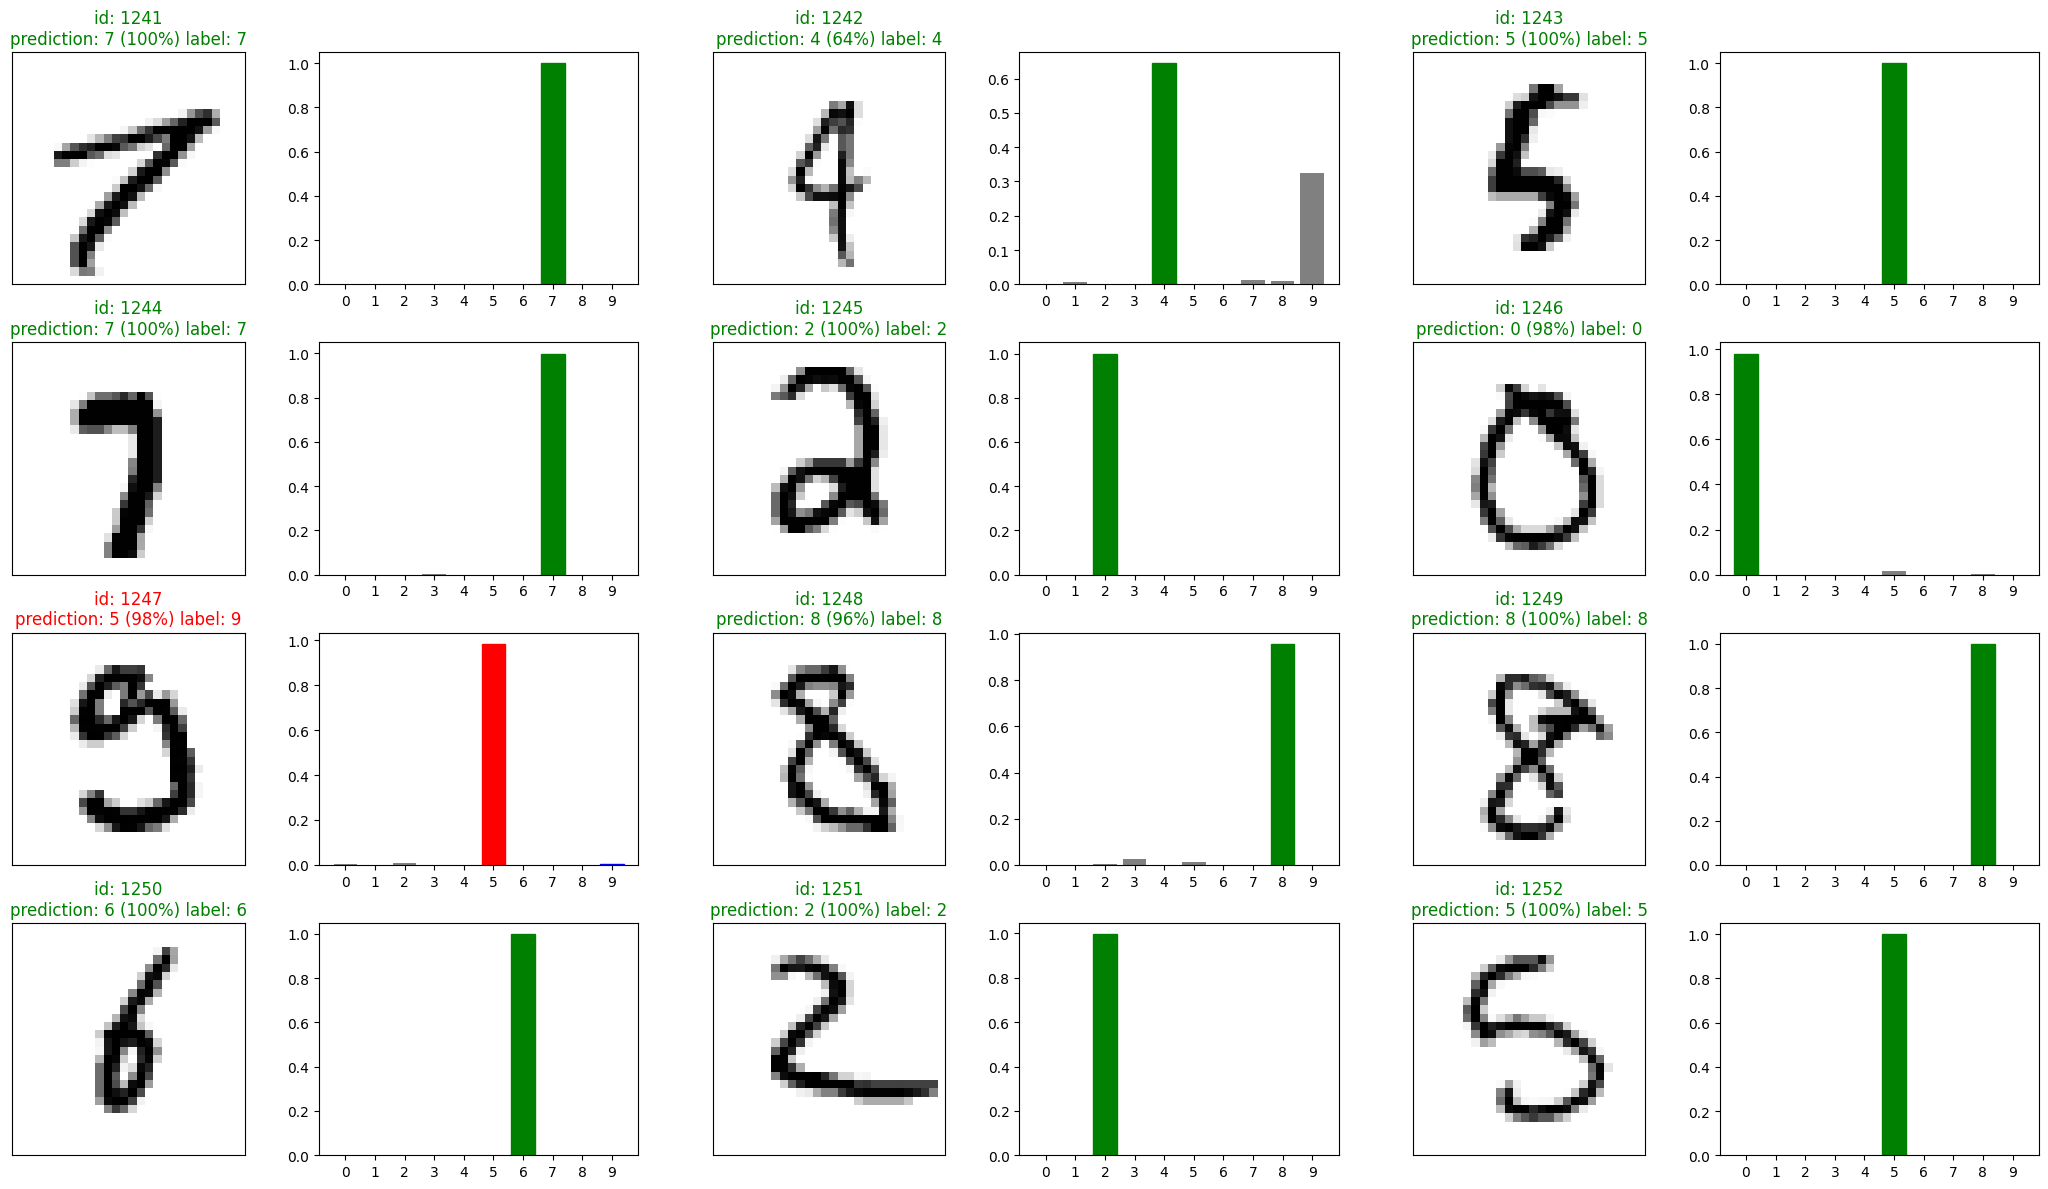

In [27]:
display_samples(MNISTPredictor(resumed_model, device), test_set, 1241)